# Pseudo-bulk functional analysis

When cell lineage is clear (there are clear cell identity clusters), it might be beneficial to perform functional analyses at the pseudo-bulk level instead of the single-cell.
By doing so, we recover lowly expressed genes that before where affected by the "drop-out" effect of single-cell. 
Additionaly, if there is more than one condition in our data, we can perform differential expression analysis (DEA) and use the gene statistics as input for enrichment analysis.

In this notebook we showcase how to use `decoupler` for pathway and transcription factor (TF) enrichment from a human data-set. The data consists of ~5k Blood myeloid cells from healthy and COVID-19 infected patients available in the Single Cell Expression Atlas [here](https://www.ebi.ac.uk/gxa/sc/experiments/E-MTAB-9221/results?plotType=umap&plotOption=20).

細胞系統が明確な場合（細胞の同一性クラスターが明確な場合）、単一細胞ではなく、擬似バルクレベルで機能解析を行うことが有益な場合がある。そうすることで、単一細胞の「脱落」効果によって影響を受けていた低発現遺伝子を回収することができる。さらに、データに複数の条件がある場合、差分発現解析（DEA）を実行し、濃縮解析の入力として遺伝子統計量を使用することができる。

このノートブックでは、ヒトのデータセットからパスウェイと転写因子（TF）を濃縮するためにdecouplerを使う方法を紹介する。データは、Single Cell Expression Atlasで入手可能な健常人とCOVID-19感染患者からの~5k Blood myeloid cellsから成る。

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

まず、関連するパッケージ、scRNA-seqデータを扱うscanpyと統計的手法を使うdecouplerをロードする必要がある。

In [1]:
# Only needed for processing
import numpy as np

In [2]:
import pandas as pd

In [3]:
# Needed for some plotting
import matplotlib.pyplot as plt

In [4]:
import scanpy as sc

In [5]:
# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

In [6]:
import decoupler as dc

In [7]:
import warnings

warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

## Loading the data

We can download the data easily using `scanpy`:

データはscanpyを使って簡単にダウンロードできる：

In [8]:
# Download data-set 
adata = sc.datasets.ebi_expression_atlas("E-MTAB-9221", filter_boring=True)

In [9]:
# Rename meta-data
columns = ['Sample Characteristic[sex]',
           'Sample Characteristic[individual]',
           'Sample Characteristic[disease]',
           'Factor Value[inferred cell type - ontology labels]']

In [10]:
adata.obs = adata.obs[columns]

In [11]:
adata.obs.columns = ['sex', 'individual', 'disease', 'cell_type']

In [12]:
adata

AnnData object with n_obs × n_vars = 6807 × 20522
    obs: 'sex', 'individual', 'disease', 'cell_type'

In [13]:
adata.obs.head()

,sex,individual,disease,cell_type
SAMEA6979313-AAACCCAAGACTCAAA,female,Control #1,normal,NaN
SAMEA6979313-AAAGAACCACCTGCTT,female,Control #1,normal,T cell
SAMEA6979313-AAAGGATGTCCCTCAT,female,Control #1,normal,monocyte
SAMEA6979313-AAAGGGTGTCCCTCAT,female,Control #1,normal,NaN
SAMEA6979313-AAAGGTTGTCCCTCAT,female,Control #1,normal,NaN


In [14]:
adata.var.head()

""
ENSG00000000003
ENSG00000000419
ENSG00000000457
ENSG00000000460
ENSG00000000938


## Processing

This specific data-set contains ensmbl gene ids instead of gene symbols. 
To be able to use `decoupler` we need to transform them into gene symbols:

このデータセットには遺伝子記号の代わりにensmbl遺伝子IDが含まれている。decouplerを使用するためには遺伝子記号に変換する必要がある：

In [15]:
# Retrieve gene symbols
annot = (
    sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name"],
        use_cache=False
    )
    .set_index("ensembl_gene_id")
)

In [16]:
annot.head()

,external_gene_name
ensembl_gene_id,
ENSG00000210049,MT-TF
ENSG00000211459,MT-RNR1
ENSG00000210077,MT-TV
ENSG00000210082,MT-RNR2
ENSG00000209082,MT-TL1


In [17]:
adata

AnnData object with n_obs × n_vars = 6807 × 20522
    obs: 'sex', 'individual', 'disease', 'cell_type'

In [18]:
# Filter genes not in annotation
adata = adata[:, adata.var.index.intersection(annot.index)]

In [19]:
# Assign gene symbols
adata.var['gene_symbol'] = [annot.loc[ensembl_id, 'external_gene_name'] for ensembl_id in adata.var.index]

In [20]:
adata

AnnData object with n_obs × n_vars = 6807 × 20449
    obs: 'sex', 'individual', 'disease', 'cell_type'
    var: 'gene_symbol'

In [21]:
adata.var = (
    adata.var
    .reset_index()
    .rename(columns={'index': 'ensembl_gene_id'})
    .set_index('gene_symbol')
)

In [22]:
adata

AnnData object with n_obs × n_vars = 6807 × 20449
    obs: 'sex', 'individual', 'disease', 'cell_type'
    var: 'ensembl_gene_id'

In [23]:
# Remove genes with no gene symbol
adata = adata[:, ~pd.isnull(adata.var.index)]

In [24]:
# Remove duplicates
adata.var_names_make_unique()

In [25]:
adata

AnnData object with n_obs × n_vars = 6807 × 19090
    obs: 'sex', 'individual', 'disease', 'cell_type'
    var: 'ensembl_gene_id'

Since the meta-data of this data-set is available, we can filter cells that were not annotated:

このデータセットのメタデータは利用可能なので、アノテーションされていないセルをフィルタリングすることができる：

In [26]:
# Remove non-annotated cells
adata = adata[~adata.obs['cell_type'].isnull()].copy()

We will store the raw counts in the `.layers` attribute so that we can use them
afterwards to generate pseudo-bulk profiles.

.layersアトリビュートに生のカウントを保存し、擬似バルクプロファイルの生成に使用できるようにする。

In [27]:
adata

AnnData object with n_obs × n_vars = 4903 × 19090
    obs: 'sex', 'individual', 'disease', 'cell_type'
    var: 'ensembl_gene_id'

In [28]:
adata.X.todense()

matrix([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
        [0.      , 1.082781, 0.      , ..., 0.      , 0.      , 0.      ],
        [0.      , 2.      , 0.      , ..., 0.      , 0.      , 0.      ],
        ...,
        [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
        [0.      , 1.      , 2.      , ..., 0.      , 0.      , 0.      ],
        [0.      , 1.      , 0.      , ..., 0.      , 0.      , 0.      ]],
       dtype=float32)

In [29]:
# Store raw counts in layers
adata.X = np.round(adata.X)

In [30]:
adata.X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 2., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 2., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [31]:
adata.layers['counts'] = adata.X.copy()

In [32]:
# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)

In [33]:
sc.pp.log1p(adata)

In [34]:
adata.layers['normalized'] = adata.X.copy()

We can also look how cells cluster by cell identity:

また、細胞のアイデンティティによって、細胞がどのようにクラスター化するかを見ることもできる：

In [35]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, batch_key='individual')

In [36]:
# Scale the data
sc.pp.scale(adata, max_value=10)

In [37]:
# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

In [38]:
# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata)

In [39]:
# Generate UMAP features
sc.tl.umap(adata)

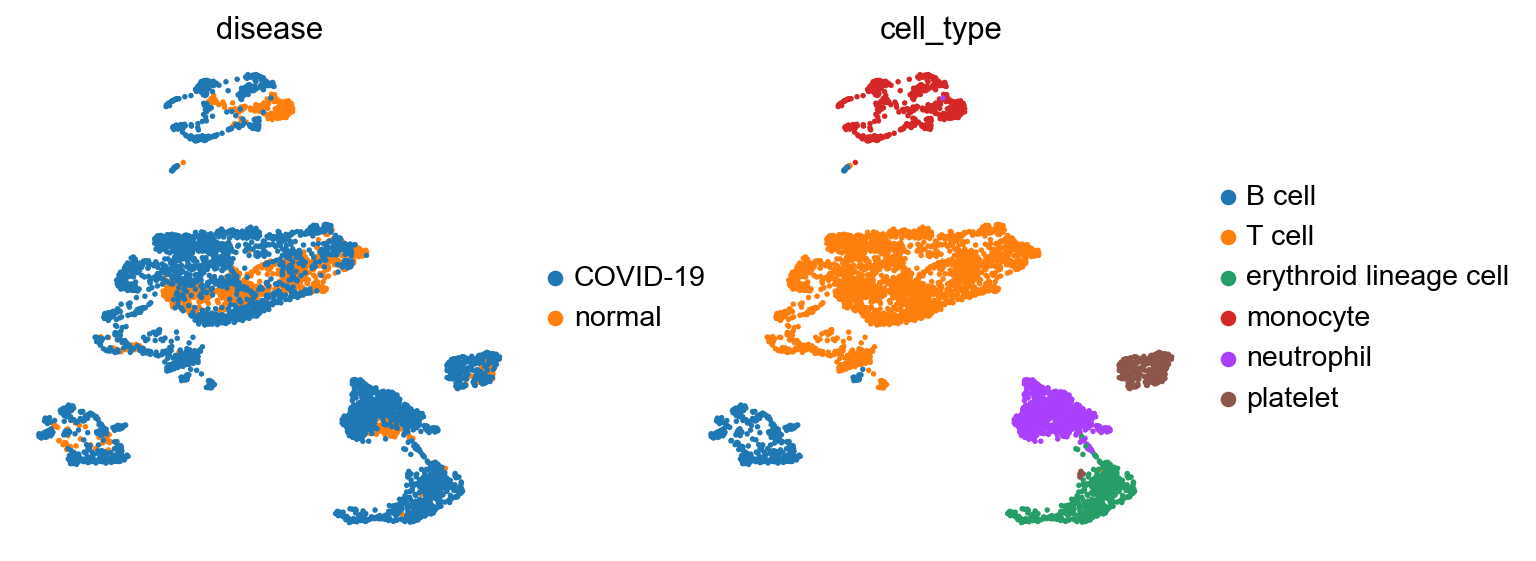

In [40]:
# Visualize
sc.pl.umap(adata, color=['disease', 'cell_type'], frameon=False)

In this data-set we have two condition, `COVID-19` and `healthy`, across 6 different cell types.

このデータセットでは、COVID-19と健常者という2つの条件、6つの異なる細胞タイプがある。

## Generation of pseudo-bulk profiles

After the annotation of clusters into cell identities, we often would like to perform differential expression analysis (DEA) between conditions within particular cell types to further characterize them. DEA can be performed at the single-cell level, but the obtained p-values are often inflated as each cell is treated as a sample. We know that single cells within a sample are not independent of each other, since they were isolated from the same environment. If we treat cells as samples, we are not testing the variation across a population of samples, rather the variation inside an individual one. Moreover, if a sample has more cells than another it might bias the results. 

The current best practice to correct for this is using a pseudo-bulk approach ([Squair J.W., et al 2021](https://doi.org/10.1038/s41467-021-25960-2)), which involves the following steps:

1. Subsetting the cell type(s) of interest to perform DEA.
2. Extracting their raw integer counts.
3. Summing their counts per gene into a single profile if they pass quality control.
4. Performing DEA if at least two biological replicates per condition are available (more replicates are recommended).

We can pseudobulk using the function `decoupler.get_pseudobulk`. In this example, we are interested in summing the counts but other
modes are available, for more information check its argument `mode`.

クラスターを細胞のアイデンティティにアノテーションした後、特定の細胞タイプ内の条件間で差次的発現解析（DEA）を行い、さらに特徴を明らかにしたいと思うことがよくある。DEAは単一細胞レベルで実行できるが、各細胞がサンプルとして扱われるため、得られるp値はしばしば膨れ上がる。サンプル内の単一細胞は、同じ環境から単離されたものであるため、互いに独立していないことが分かっている。細胞をサンプルとして扱うと、サンプルの集団全体のばらつきを検定するのではなく、個々のサンプル内のばらつきを検定することになる。さらに、あるサンプルに他のサンプルより多くの細胞があれば、結果に偏りが出るかもしれない。

これを補正するための現在のベスト・プラクティスは、擬似バルク・アプローチ（Squair J.W., et al 2021）を用いることであり、これには以下のステップが含まれる：

- DEAを実施するために、対象となる細胞タイプをサブセットする。
- 生の整数カウントを抽出する。
- 品質管理に合格した場合、遺伝子ごとのカウントを1つのプロファイルに合計する。
- 条件ごとに少なくとも2つの生物学的複製が利用可能であれば、DEAを実行する（より多くの複製が推奨される）。

decoupler.get_pseudobulk関数を用いて擬似バルクを得ることができる。この例ではカウントの合計に興味があるが、他のモードも利用可能である。

In [51]:
adata

AnnData object with n_obs × n_vars = 4903 × 19090
    obs: 'sex', 'individual', 'disease', 'cell_type'
    var: 'ensembl_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'disease_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'distances', 'connectivities'

In [41]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='individual',
    groups_col='cell_type',
    layer='counts',
    mode='sum',
    min_cells=0,
    min_counts=0
)

In [42]:
pdata

AnnData object with n_obs × n_vars = 39 × 18431
    obs: 'sex', 'individual', 'disease', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    layers: 'psbulk_props'

It has generated a profile for each sample and cell type. We can plot their quality control metrics:

各サンプルと細胞タイプのプロファイルが生成されました。その品質管理指標をプロットすることができる：

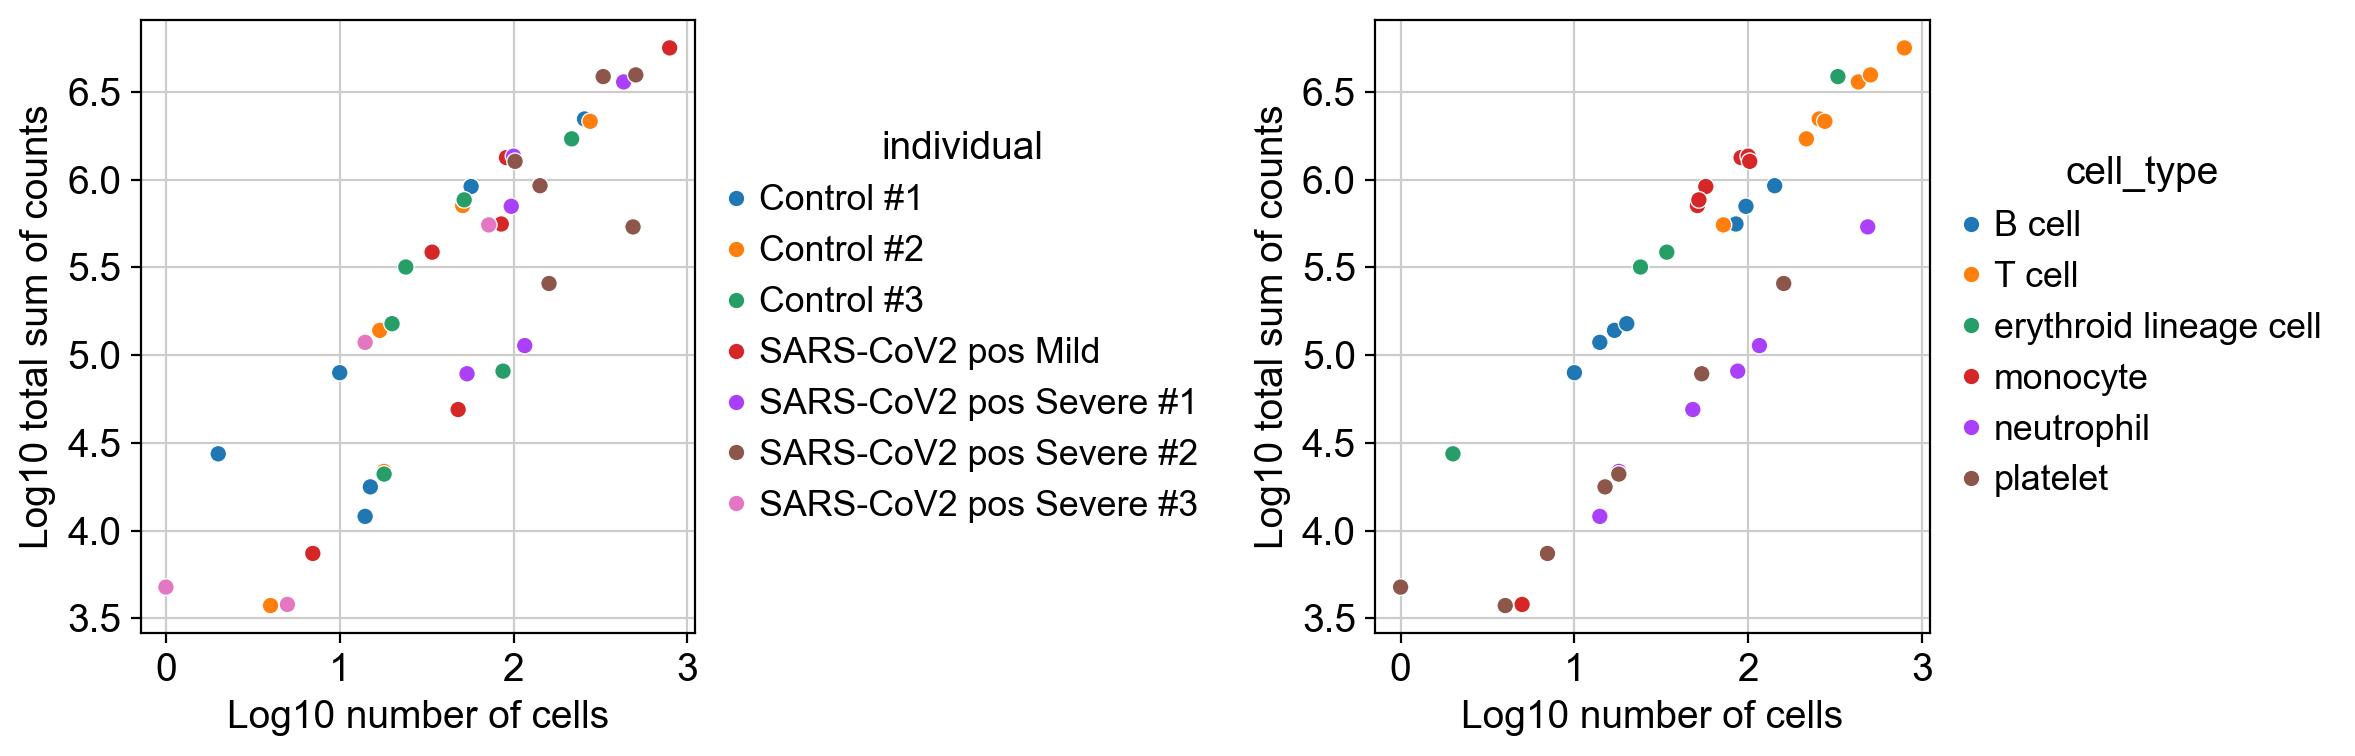

In [43]:
dc.plot_psbulk_samples(
    pdata, groupby=['individual', 'cell_type'],
    figsize=(12, 4)
)

There are two criteria to filter low quality samples: its number of cells (`psbulk_n_cells`), and its total sum of counts (`psbulk_counts`).
In these plots it can be seen that there are some samples of platelet cells that contain less than 10 cells, we might want to remove
them by using the arguments `min_cells` and `min_counts`. Note that these thresholds are arbitrary and will change depening on the
dataset, but a good rule of thumb is to have at least 10 cells with 1000 accumulated counts.

低品質サンプルをフィルターする2つの基準がある：細胞数（psbulk_n_cells）と総カウント数（psbulk_counts）。これらのプロットでは、血小板細胞のサンプルの中には10個以下の細胞しか含まれていないものがあることがわかる。これらの閾値は任意であり、データセットによって変わるが、経験則としては、1000の累積カウントで少なくとも10個の細胞があることが望ましい。

In [44]:
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='individual',
    groups_col='cell_type',
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=1000
)

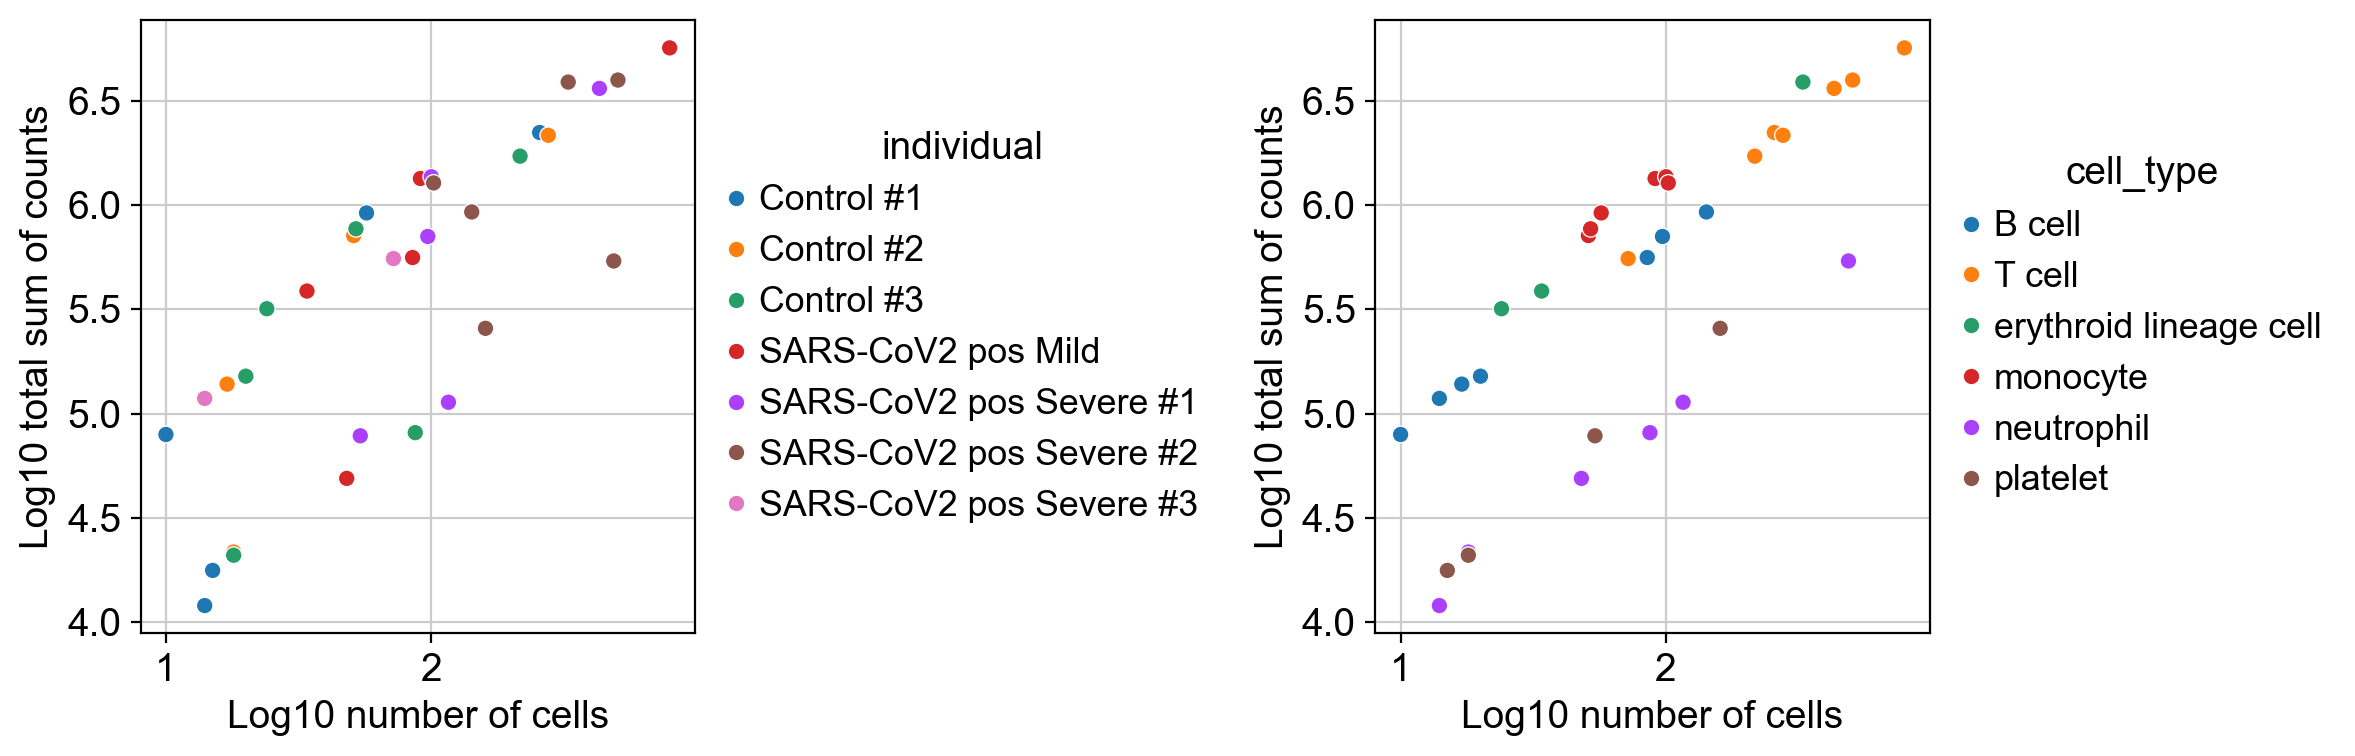

In [48]:
dc.plot_psbulk_samples(
    pdata, groupby=['individual', 'cell_type'],
    figsize=(12, 4)
)

In [45]:
pdata

AnnData object with n_obs × n_vars = 34 × 18431
    obs: 'sex', 'individual', 'disease', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    layers: 'psbulk_props'

In [46]:
pdata.obs.head()

,sex,individual,disease,cell_type,psbulk_n_cells,psbulk_counts
Control #1_B cell,female,Control #1,normal,B cell,10.0,79455.0
Control #2_B cell,female,Control #2,normal,B cell,17.0,138515.0
Control #3_B cell,female,Control #3,normal,B cell,20.0,151168.0
SARS-CoV2 pos Mild_B cell,female,SARS-CoV2 pos Mild,COVID-19,B cell,85.0,559591.0
SARS-CoV2 pos Severe #1_B cell,male,SARS-CoV2 pos Severe #1,COVID-19,B cell,97.0,705935.0


In [47]:
pdata.var.head()

,ensembl_gene_id,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,mean,std
gene_symbol,,,,,,,,,
5S_rRNA,ENSG00000288601,False,0.020579,0.407888,0.235177,1,False,0.000858,0.041410
A1BG,ENSG00000121410,False,0.267614,1.122076,0.218030,3,False,0.133543,0.350279
A2M,ENSG00000175899,False,0.102607,0.716655,-0.051473,0,False,0.045143,0.215639
A2MP1,ENSG00000256069,False,0.053359,0.853178,0.195683,1,False,0.024446,0.163141
A4GALT,ENSG00000128274,False,0.012281,0.530494,-0.301318,1,False,0.006759,0.080131


In [50]:
pdata.X

array([[  0.,   3.,   0., ...,   1.,  28.,   0.],
       [  0.,   7.,   0., ...,   2.,  60.,   1.],
       [  0.,   6.,   0., ...,   0.,  25.,   1.],
       ...,
       [  0.,   0.,   0., ...,   6.,   1.,   0.],
       [  0.,  13.,   0., ...,  38.,   2.,   0.],
       [  0.,   7.,   0., ..., 175.,   6.,   1.]], dtype=float32)

In [61]:
pdata.layers['psbulk_props']

array([[0.        , 0.3       , 0.        , ..., 0.1       , 0.9       ,
        0.        ],
       [0.        , 0.23529412, 0.        , ..., 0.11764706, 0.88235294,
        0.05882353],
       [0.        , 0.25      , 0.        , ..., 0.        , 0.65      ,
        0.05      ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.27777778, 0.05555556,
        0.        ],
       [0.        , 0.18518519, 0.        , ..., 0.37037037, 0.03703704,
        0.        ],
       [0.        , 0.0375    , 0.        , ..., 0.5625    , 0.0375    ,
        0.00625   ]])

### Exploration of pseudobulk profiles
Now that we have generated the pseudobulk profiles for each patient and each cell type, let's explore the variability between them. For that, we will first do some simple preprocessing and then do a PCA

さて、各患者と各細胞タイプについて擬似バルク・プロ ファイルを作成したので、それらの間のばらつきを調べて みよう。そのために、まず簡単な前処理を行い、次にPCAを行います。

In [52]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

In [53]:
# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)

In [54]:
sc.pp.log1p(pdata)

In [55]:
sc.pp.scale(pdata, max_value=10)

In [56]:
sc.tl.pca(pdata)

In [57]:
# Return raw counts to X
dc.swap_layer(pdata, layer_key='counts', X_layer_key=None, inplace=True)

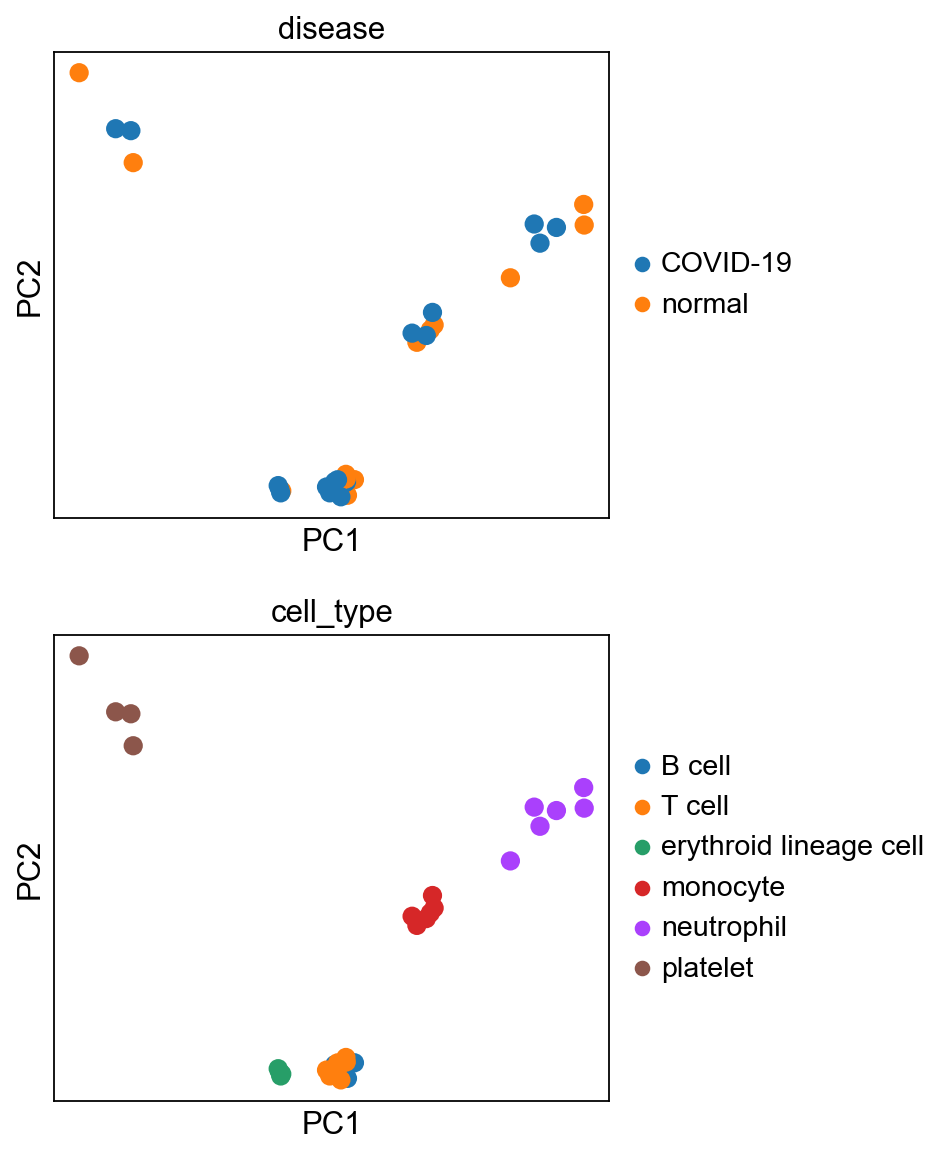

In [58]:
sc.pl.pca(pdata, color=['disease', 'cell_type'], ncols=1, size=300)

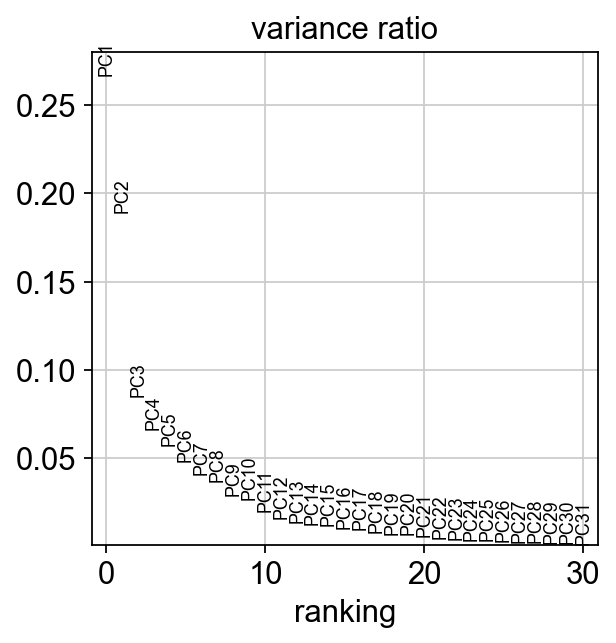

In [59]:
sc.pl.pca_variance_ratio(pdata)

When looking at the PCA, it seems like the two first components explain most of the variance and they easily separate cell types from one another. In contrast, the principle components do not seem to be associated with disease status as such.

In order to have a better overview of the association of PCs with sample metadata, let's perform ANOVA on each PC and see whether they are significantly associated with any technical or biological annotations of our samples

PCAを見ると、2つの第1成分が分散のほとんどを説明し、細胞タイプ同士を簡単に分離しているように見える。対照的に、主成分は病気の状態とは関連性がないようです。

PCとサンプルのメタデータとの関連をよりよく概観するために、各PCでANOVAを実行し、サンプルの技術的または生物学的アノテーションと有意に関連しているかどうかを見てみましょう。

In [60]:
pdata

AnnData object with n_obs × n_vars = 34 × 18431
    obs: 'sex', 'individual', 'disease', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'pca', 'disease_colors', 'cell_type_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

In [62]:
dc.get_metadata_associations(
    pdata,
    obs_keys=[
        'sex', 'disease', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'
    ],  # Metadata columns to associate to PCs
    obsm_key='X_pca',  # Where the PCs are stored
    uns_key='pca_anova',  # Where the results are stored
    inplace=True,
)

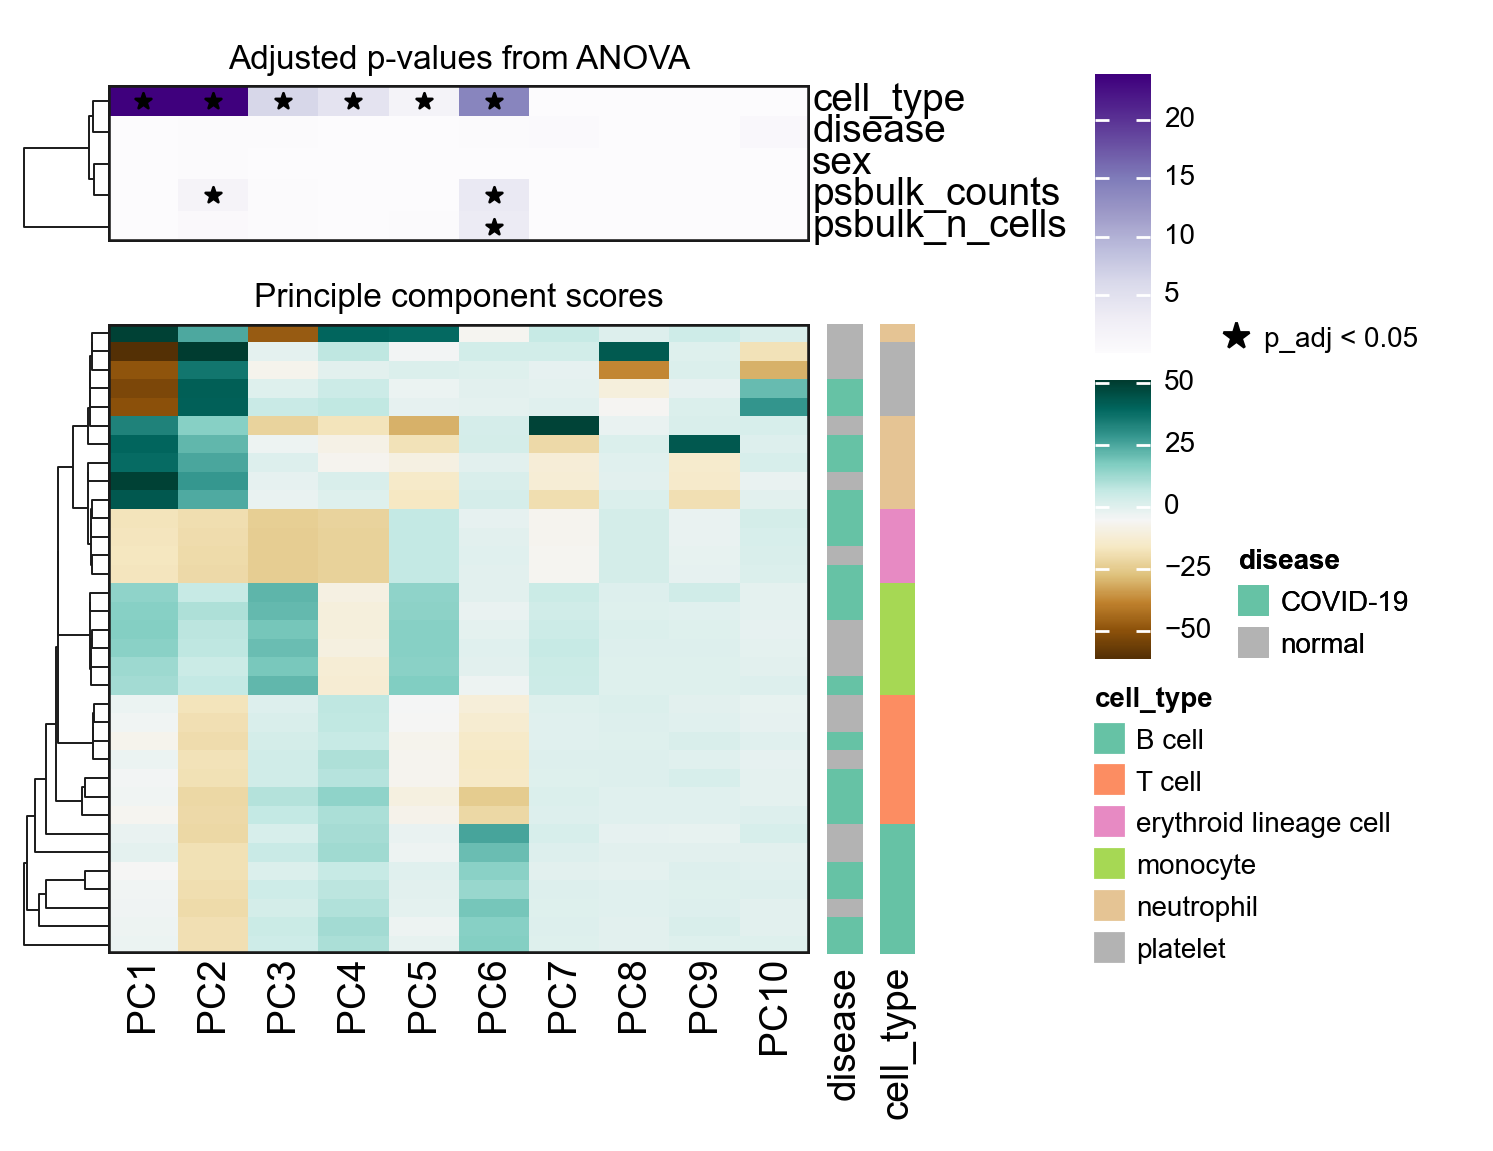

In [63]:
dc.plot_associations(
    pdata,
    uns_key='pca_anova',  # Summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # Which summary statistic to plot
    obs_annotation_cols=[
        'disease', 'cell_type'
    ],  # which sample annotations to plot
    titles=['Principle component scores', 'Adjusted p-values from ANOVA'],
    figsize=(7, 5),
    n_factors=10,
)

On the PCA plots above, T and B cells seemed not to be that well separated. However when looking at the hierarchical clustering in the heatmap, one can see that the inclusion of more PCs helps to distinguish them.

When looking at the p-values from the ANOVA models, it becomes clear that the top PCs, which explain most of the observed variability, are statistically associated with the `cell_type` category.

上のPCAプロットでは、T細胞とB細胞はそれほどうまく分離されていないように見えた。しかし、ヒートマップの階層的クラスタリングを見ると、より多くのPCが含まれることで、両者を区別するのに役立っていることがわかる。

ANOVAモデルから得られたp値を見ると、観察された変動の大部分を説明する上位のPCは、cell_typeカテゴリーと統計的に関連していることが明らかになりました。

### Pseudo-bulk profile gene filtering
Additionally to filtering low quality samples, we can also filter noisy expressed genes in case we want to perform downstream analyses such as DEA afterwards. Note that this step should be done at the cell type level, since each cell type may express different collection of genes.

For this vignette, we will explore the effects of COVID on T cells. Let's first select our samples of interest:

低品質サンプルのフィルタリングに加え、DEAのようなダウンストリーム解析を行った後にノイズの多い発現遺伝子をフィルタリングすることもできる。細胞種によって発現する遺伝子のコレクションが異なる可能性があるため、このステップは細胞種レベルで行う必要があることに注意されたい。

このヴィネットでは、T細胞に対するCOVIDの効果を探索する。まず目的のサンプルを選択しよう：

In [64]:
# Select T cell profiles
tcells = pdata[pdata.obs['cell_type'] == 'T cell'].copy()

To filter genes, we will follow the strategy implemented in the function `filterByExpr` from [edgeR](https://rdrr.io/bioc/edgeR/man/filterByExpr.html).
It keeps genes that have a minimum total number of reads across samples (`min_total_count`), and that have a minimum number of counts in a number of samples (`min_count`).

We can plot how many genes do we keep, you can play with the `min_count` and `min_total_count` to check how many genes would be kept when changed:

遺伝子をフィルタリングするために、edgeRのfilterByExpr関数に実装されている戦略に従う。これは、サンプル間のリード総数が最小の遺伝子（min_total_count）と、サンプル数のカウント数が最小の遺伝子（min_count）を保持する。

min_countとmin_total_countを弄ることで、いくつの遺伝子を残すかをプロットできる：

In [65]:
?dc.plot_filter_by_expr

Signature:
dc.plot_filter_by_expr(
    adata,
    obs=None,
    group=None,
    lib_size=None,
    min_count=10,
    min_total_count=15,
    large_n=10,
    min_prop=0.7,
    cmap='viridis',
    figsize=(5, 4),
    dpi=100,
    ax=None,
    return_fig=False,
    save=None,
    **kwargs,
)
Docstring:
Plot to help determining the thresholds of the ``decoupler.filter_by_expr`` function.

Parameters
----------
adata : AnnData
    AnnData obtained after running ``decoupler.get_pseudobulk``.
obs : DataFrame, None
    If provided, metadata dataframe, only needed if ``adata`` is not an ``AnnData``.
group : str, None
    Name of the ``.obs`` column to group by. If None, it assumes that all samples belong to one group.
lib_size : int, float, None
    Library size. If None, default to the sum of reads per sample.
min_count : int
    Minimum count requiered per gene for at least some samples.
min_total_count : int
    Minimum total count required per gene across all samples.
large_n : int
    Numb

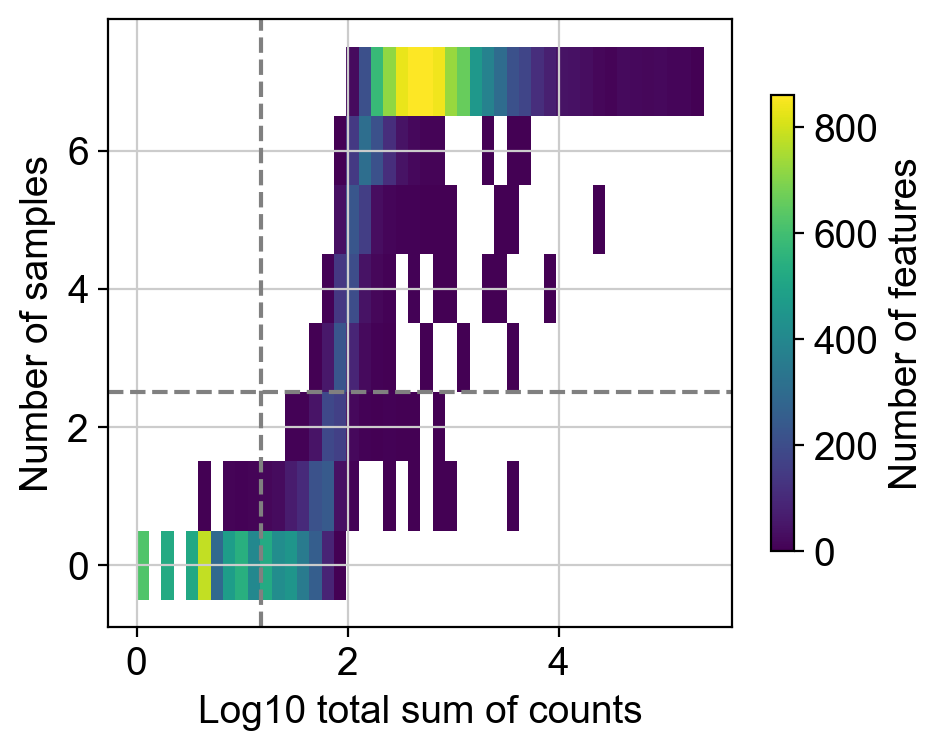

In [53]:
dc.plot_filter_by_expr(
    tcells, group='disease',
    min_count=10, min_total_count=15
)

Here we can observe the frequency of genes with different total sum of counts and number of samples. The dashed lines indicate the current thresholds, meaning that only the genes in the upper-right corner are going to be kept. Filtering parameters is completely arbitrary, but a good rule of thumb is to identify bimodal distributions and split them modifying the available thresholds.
In this example, with the default values we would keep a good quantity of genes while filtering potential noisy genes.
    
Changing the value of `min_count` will drastically change the distribution of "Number of samples", not change its threshold.
In case you want to lower or increase it, you need to play with the `group`, `large_n` and `min_prop` parameters.

Once we are content with the threshold parameters, we can perform the actual filtering:

ここでは、総カウント数とサンプル数が異なる遺伝子の頻度を観察できる。破線は現在の閾値を示し、右上隅の遺伝子だけが保持されることを意味する。パラメーターのフィルタリングは完全に任意であるが、経験則としては、二峰性の分布を識別し、利用可能な閾値を変更してそれらを分割することである。この例では、デフォルト値で、潜在的にノイズの多い遺伝子をフィルタリングしながら、十分な量の遺伝子を残すことになる。

min_countの値を変更すると、"Number of samples "の分布が大きく変わるが、閾値は変わらない。閾値を下げたり上げたりしたい場合は、group、large_n、min_propパラメータを調整する必要がある。

しきい値パラメータに満足したら、実際のフィルタリングを行うことができる：

In [66]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(
    tcells, group='disease',
    min_count=10, min_total_count=15
)

In [67]:
# Filter by these genes
tcells = tcells[:, genes].copy()

In [68]:
tcells

AnnData object with n_obs × n_vars = 7 × 10421
    obs: 'sex', 'individual', 'disease', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'pca', 'disease_colors', 'cell_type_colors', 'pca_anova'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

Another filtering strategy is to filter out genes that are not expressed in a percentage of cells and samples, as implemented
in `decoupler.filter_by_prop`.

もう一つのフィルタリング戦略は、decoupler.filter_by_propで実装されているように、細胞やサンプルの割合で発現していない遺伝子をフィルタリングすることである。

## Contrast between conditions
Once we have generated robust pseudo-bulk profiles, we can compute DEA. For this example, we will perform a simple
experimental design where we compare the gene expression of T cells from diseased patients against controls. We will use the
python implementation of the framework DESeq2, but we could have used any other one (`limma` or `edgeR` for example).
For a better understanding how it works, check [DESeq2's documentation](https://pydeseq2.readthedocs.io/en/latest/). Note that
more complex experimental designs can be used by adding more factors to the `design_factors` argument.

ロバストな擬似バルクプロファイルが生成できたら、DEAを計算することができる。この例では、疾患患者のT細胞の遺伝子発現をコントロールと比較する単純な実験計画を行う。DESeq2フレームワークのpython実装を使用しますが、他のもの（例えばlimmaやedgeR）を使用することもできます。DESeq2がどのように機能するかについては、DESeq2のドキュメントを参照されたい。design_factors引数に因子を追加することで、より複雑な実験計画を使用できることに注意してください。

In [69]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [70]:
# Build DESeq2 object
inference = DefaultInference(n_cpus=8)

In [75]:
tcells.obs.head()

,sex,individual,disease,cell_type,psbulk_n_cells,psbulk_counts
Control #1_T cell,female,Control #1,normal,T cell,256.0,2221792.0
Control #2_T cell,female,Control #2,normal,T cell,276.0,2154689.0
Control #3_T cell,female,Control #3,normal,T cell,216.0,1711323.0
SARS-CoV2 pos Mild_T cell,female,SARS-CoV2 pos Mild,COVID-19,T cell,791.0,5649814.0
SARS-CoV2 pos Severe #1_T cell,male,SARS-CoV2 pos Severe #1,COVID-19,T cell,430.0,3613425.0


In [76]:
?DeseqDataSet

Init signature:
DeseqDataSet(
    *,
    adata: Optional[anndata._core.anndata.AnnData] = None,
    counts: Optional[pandas.core.frame.DataFrame] = None,
    metadata: Optional[pandas.core.frame.DataFrame] = None,
    design_factors: Union[str, List[str]] = 'condition',
    continuous_factors: Optional[List[str]] = None,
    ref_level: Optional[List[str]] = None,
    fit_type: Literal['parametric', 'mean'] = 'parametric',
    min_mu: float = 0.5,
    min_disp: float = 1e-08,
    max_disp: float = 10.0,
    refit_cooks: bool = True,
    min_replicates: int = 7,
    beta_tol: float = 1e-08,
    n_cpus: Optional[int] = None,
    inference: Optional[pydeseq2.inference.Inference] = None,
    quiet: bool = False,
) -> None
Docstring:     
A class to implement dispersion and log fold-change (LFC) estimation.

The DeseqDataSet extends the `AnnData class
<https://anndata.readthedocs.io/en/latest/generated/anndata.AnnData.html#anndata.AnnData>`_.
As such, it implements the same methods and attri

In [71]:
dds = DeseqDataSet(
    adata=tcells,
    design_factors='disease',
    ref_level=['disease', 'normal'],
    refit_cooks=True,
    inference=inference,
)

In [72]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.90 seconds.

Fitting dispersion trend curve...
... done in 0.33 seconds.

Fitting MAP dispersions...
... done in 3.13 seconds.

Fitting LFCs...
... done in 1.93 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [77]:
# Extract contrast between COVID-19 vs normal
stat_res = DeseqStats(
    dds,
    contrast=["disease", 'COVID-19', 'normal'],
    inference=inference,
)

In [78]:
# Compute Wald test
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: disease COVID-19 vs normal
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                             
A1BG          70.472333       -0.202972  0.259150 -0.783221  0.433497   
A2M           36.734556       -1.260096  0.355288 -3.546687  0.000390   
A2MP1         15.628607        0.601969  0.702298  0.857142  0.391366   
AAAS          18.306753        0.254730  0.453785  0.561346  0.574562   
AACS          24.631571        0.259419  0.383281  0.676837  0.498509   
...                 ...             ...       ...       ...       ...   
ZXDC          30.182078       -0.289481  0.373684 -0.774668  0.438536   
ZYG11B       101.888760        0.270046  0.298363  0.905092  0.365417   
ZYX           81.602910        0.303807  0.264873  1.146991  0.251385   
ZZEF1        820.808680        0.028006  0.224459  0.124774  0.900703   
ZZZ3          59.930169       -0.075178  0.304090 -0.247221

... done in 0.75 seconds.



In [79]:
# Extract results
results_df = stat_res.results_df

In [80]:
results_df.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
A1BG,70.472333,-0.202972,0.259150,-0.783221,0.433497,0.847778
A2M,36.734556,-1.260096,0.355288,-3.546687,0.000390,0.031807
A2MP1,15.628607,0.601969,0.702298,0.857142,0.391366,0.829075
AAAS,18.306753,0.254730,0.453785,0.561346,0.574562,0.899853
AACS,24.631571,0.259419,0.383281,0.676837,0.498509,0.872643


We can plot the obtained results in a volcano plot:

得られた結果をボルケーノプロットにプロットすることができる：

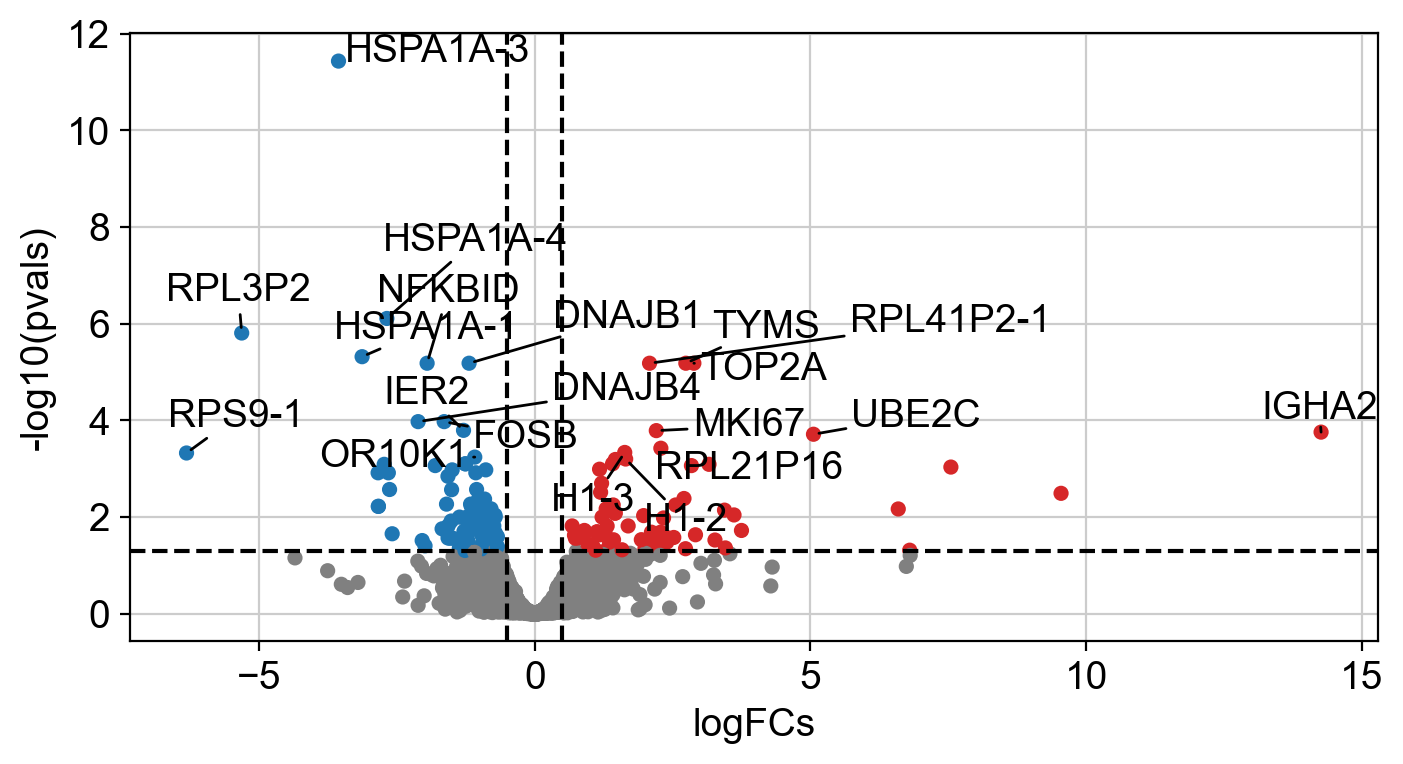

In [81]:
dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(8, 4)
)

After performing DEA, we can use the obtained gene level statistics to perform enrichment analysis. Any statistic can be used,
but we recommend using the t-values instead of logFCs since t-values incorporate the significance of change in their value.
We will transform the obtained t-values stored in `stats` to a wide matrix so that it can be used by `decoupler`:

DEAを行った後、得られた遺伝子レベルの統計量を用いて濃縮解析を行うことができる。どのような統計量でも使用できるが、logFCの代わりにt値を使用することを推奨する。t値はその値に変化の有意性が含まれているからである。statsに格納されたt値をワイド行列に変換し、decouplerで利用できるようにする：

In [89]:
mat = results_df[['stat']].T.rename(index={'stat': 'T cell'})

In [90]:
mat

gene_symbol,A1BG,A2M,A2MP1,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZUP1,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
T cell,-0.783221,-3.546687,0.857142,0.561346,0.676837,-0.098665,-0.639947,0.243019,0.946782,0.508839,...,1.37931,1.291285,3.581628,-0.866258,-1.960317,-0.774668,0.905092,1.146991,0.124774,-0.247221


## Transcription factor activity inference

The first functional analysis we can perform is to infer transcription factor (TF) activities from our transcriptomics data. We will need a gene regulatory network (GRN) and a statistical method.

### CollecTRI network
[CollecTRI](https://github.com/saezlab/CollecTRI) is a comprehensive resource
containing a curated collection of TFs and their transcriptional targets
compiled from 12 different resources. This collection provides an increased
coverage of transcription factors and a superior performance in identifying
perturbed TFs compared to our previous
[DoRothEA](https://saezlab.github.io/dorothea/) network and other literature
based GRNs. Similar to DoRothEA, interactions are weighted by their mode of
regulation (activation or inhibition).

For this example we will use the human version (mouse and rat are also
available). We can use `decoupler` to retrieve it from `omnipath`. The argument
`split_complexes` keeps complexes or splits them into subunits, by default we
recommend to keep complexes together.

最初に行う機能解析は、トランスクリプトミクスデータから転写因子（TF）活性を推測することである。遺伝子制御ネットワーク（GRN）と統計的手法が必要です。

CollecTRIは、12の異なるリソースからコンパイルされたTFとその転写ターゲットのキュレーションコレクションを含む包括的なリソースです。このコレクションは、以前のDoRothEAネットワークや他の文献ベースのGRNと比較して、転写因子のカバレッジを高め、摂動TFの同定において優れたパフォーマンスを提供します。DoRothEAと同様に、相互作用はその調節様式（活性化または阻害）によって重み付けされる。

この例ではヒトのバージョンを使用する（マウスとラットも利用可能）。decouplerを使ってomnipathから取り出すことができる。引数split_complexesは複合体を保持するかサブユニットに分割するかを指定する。デフォルトでは複合体を保持することを推奨する。

In [91]:
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(
    organism='human', split_complexes=False
)

In [92]:
collectri.head()

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...


### Activity inference with Univariate Linear Model (ULM)

To infer TF enrichment scores we will run the Univariate Linear Model (`ulm`) method. For each sample in our dataset (`mat`) and each TF in our network (`net`), it fits a linear model that predicts the observed gene expression
based solely on the TF's TF-Gene interaction weights. Once fitted, the obtained t-value of the slope is the score. If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive.

We can run `ulm` with a one-liner:

TF濃縮スコアを推測するために、一変量線形モデル（ulm）法を実行する。データセットの各サンプル（mat）とネットワークの各TF（net）について、TFのTF-遺伝子相互作用の重みのみに基づいて、観測された遺伝子発現を予測する線形モデルを当てはめる。フィッティング後、得られた傾きのt値がスコアとなる。これが正であればTFは活性であると解釈し、負であれば不活性であると解釈する。

ulmはワンライナーで実行できる：

In [93]:
# Infer pathway activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri)

In [94]:
tf_acts

,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID3B,ARID4A,ARID5B,ARNT,...,ZNF350,ZNF354C,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF91
T cell,0.458565,1.358595,-1.868703,-1.754337,0.441808,-0.055122,-0.138667,0.069371,0.570765,-0.706567,...,0.183652,-2.472609,1.283082,0.391707,-1.727347,1.069249,0.30299,-0.621513,1.816132,-1.938027


In [95]:
tf_pvals

,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID3B,ARID4A,ARID5B,ARNT,...,ZNF350,ZNF354C,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF91
T cell,0.646556,0.174304,0.061692,0.079402,0.658637,0.956042,0.889716,0.944695,0.568171,0.479851,...,0.85429,0.013429,0.199492,0.695283,0.084135,0.284982,0.761903,0.534276,0.069379,0.052647


Let us plot the obtained scores for the top active/inactive transcription factors:

上位の活性／不活性転写因子について、得られたスコアをプロットしてみよう：

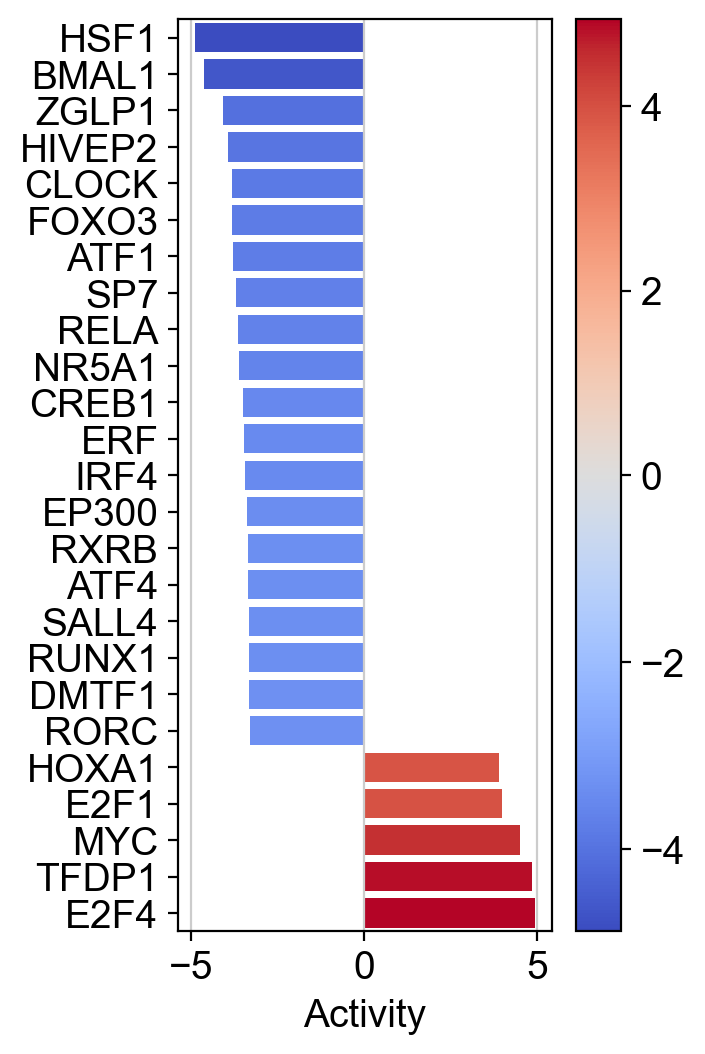

In [96]:
dc.plot_barplot(
    acts=tf_acts,
    contrast='T cell',
    top=25,
    vertical=True,
    figsize=(3, 6)
)

In accordance to the previous pathway results, T cells seem to activate for TFs responsible for cell growth (E2F4, TFDP1, E2F1).

Like with pathways, we can explore how the target genes look like:

前回のパスウェイの結果と同様に、T細胞は細胞増殖に関与するTF（E2F4、TFDP1、E2F1）を活性化するようだ。

パスウェイと同様に、標的遺伝子がどのように見えるかを探ることができる：

In [98]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'T cell'})
pvals = results_df[['padj']].T.rename(index={'padj': 'T cell'})

In [99]:
logFCs

gene_symbol,A1BG,A2M,A2MP1,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZUP1,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
T cell,-0.202972,-1.260096,0.601969,0.25473,0.259419,-0.035807,-0.154623,0.09899,0.315498,0.1869,...,0.622263,0.762406,1.932051,-0.410806,-1.006428,-0.289481,0.270046,0.303807,0.028006,-0.075178


In [100]:
pvals

gene_symbol,A1BG,A2M,A2MP1,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZUP1,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
T cell,0.847778,0.031807,0.829075,0.899853,0.872643,0.988775,0.882952,0.961618,0.805203,0.911076,...,0.658095,0.688213,0.029298,0.827282,0.426208,0.850319,0.814004,0.743798,0.983408,0.960555


In [101]:
collectri.head()

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...


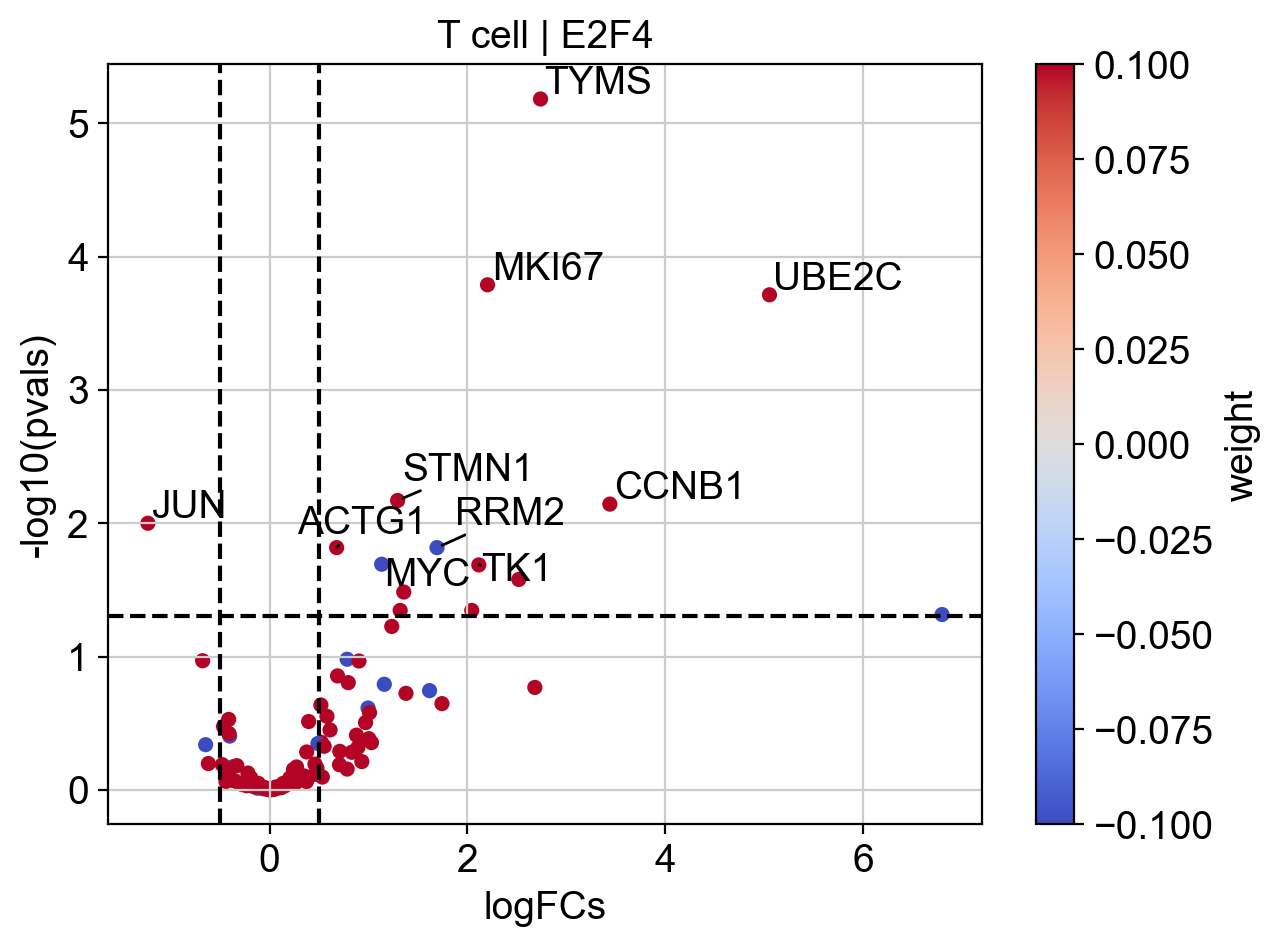

In [102]:
# Plot
dc.plot_volcano(
    logFCs=logFCs,
    pvals=pvals,
    contrast='T cell',
    name='E2F4',
    net=collectri,
    top=10,
    sign_thr=0.05,
    lFCs_thr=0.5
)

We can also plot the network of interesting TFs (top and bottom by activity) and color the nodes by activity and target gene expression:

また、興味深いTFのネットワークをプロットし（活性別に上下に）、活性と標的遺伝子発現によってノードを色分けすることもできる：

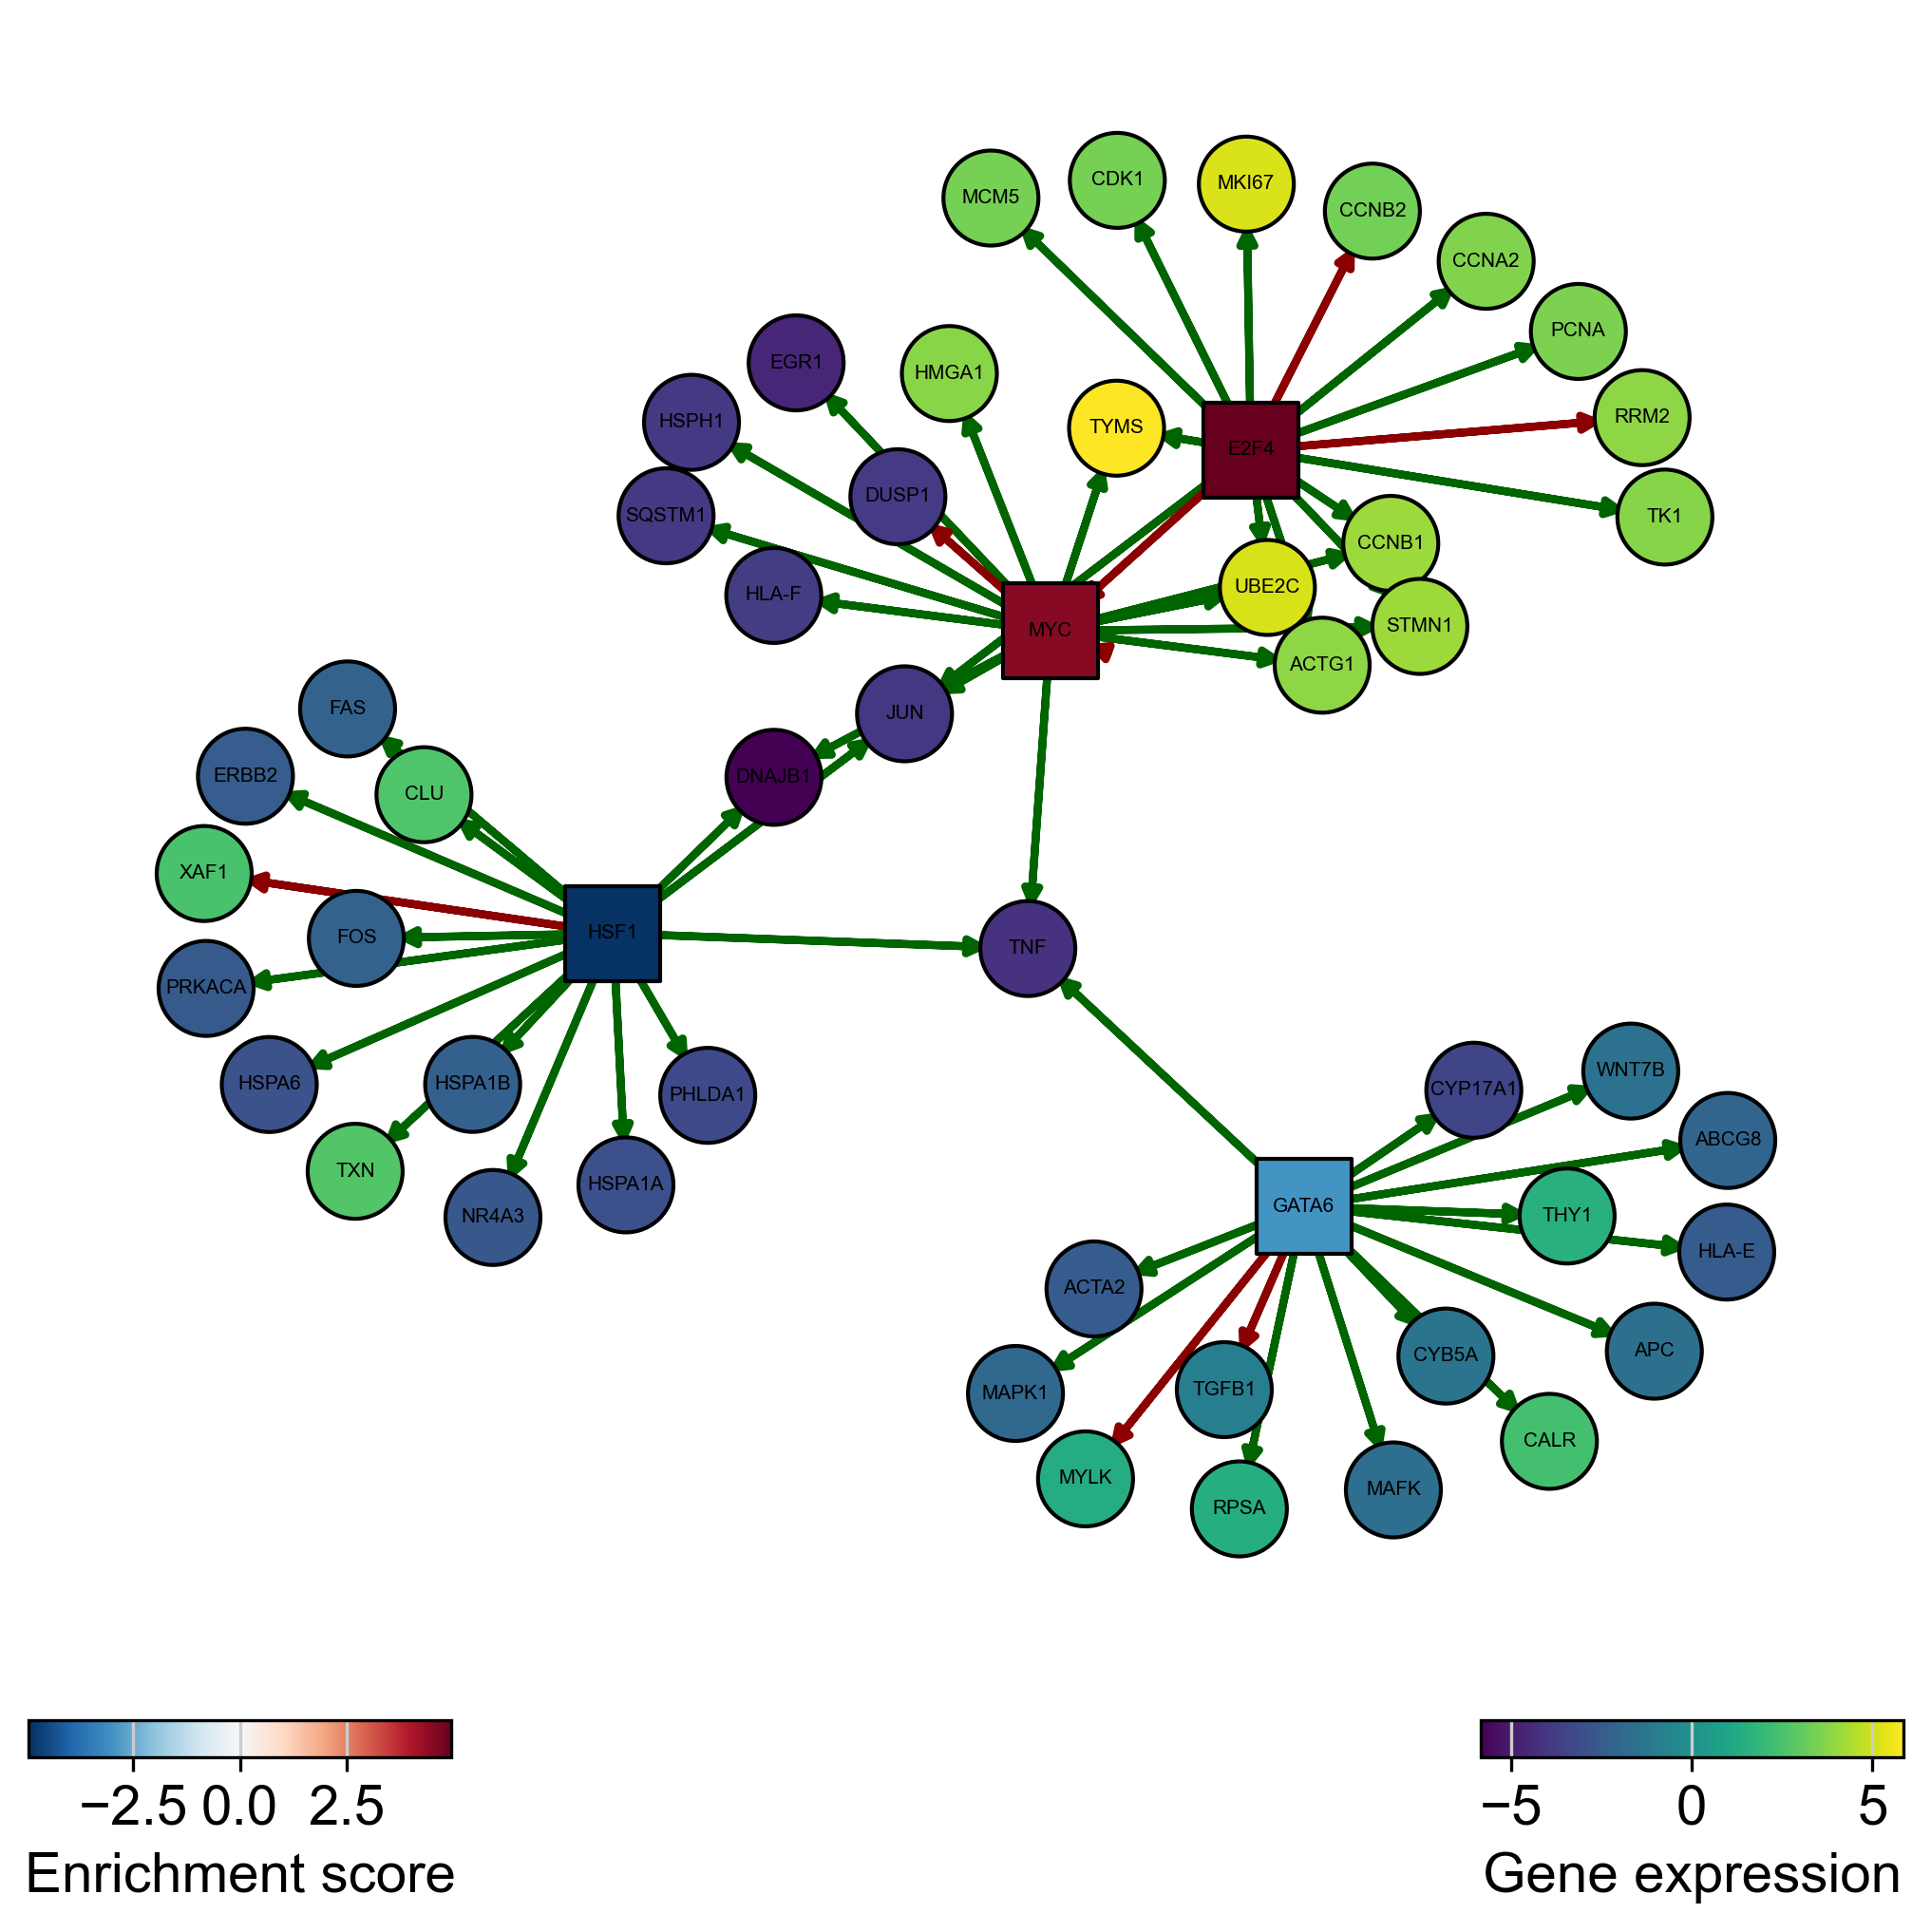

In [103]:
dc.plot_network(
    net=collectri,
    obs=mat,
    act=tf_acts,
    n_sources=['MYC', 'E2F4', 'HSF1', 'GATA6'],
    n_targets=15,
    node_size=100,
    figsize=(7, 7),
    c_pos_w='darkgreen',
    c_neg_w='darkred',
    vcenter=True
)

Green edges are positive regulation (activation), red edges are negative regulation (inactivation):

緑のエッジは正の調節（活性化）、赤のエッジは負の調節（不活性化）：

## Pathway activity inference

Another analysis we can perform is to infer pathway activities from our transcriptomics data.

### PROGENy model

[PROGENy](https://saezlab.github.io/progeny/) is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction.
For this example we will use the human weights (other organisms are available) and we will use the top 500 responsive genes ranked by p-value. Here is a brief description of each pathway:

- **Androgen**: involved in the growth and development of the male reproductive organs.
- **EGFR**: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- **Estrogen**: promotes the growth and development of the female reproductive organs.
- **Hypoxia**: promotes angiogenesis and metabolic reprogramming when O2 levels are low.
- **JAK-STAT**: involved in immunity, cell division, cell death, and tumor formation.
- **MAPK**: integrates external signals and promotes cell growth and proliferation.
- **NFkB**: regulates immune response, cytokine production and cell survival.
- **p53**: regulates cell cycle, apoptosis, DNA repair and tumor suppression.
- **PI3K**: promotes growth and proliferation.
- **TGFb**: involved in development, homeostasis, and repair of most tissues.
- **TNFa**: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.
- **Trail**: induces apoptosis.
- **VEGF**: mediates angiogenesis, vascular permeability, and cell migration.
- **WNT**: regulates organ morphogenesis during development and tissue repair.

To access it we can use `decoupler`.

トランスクリプトミクス・データからパスウェイ活性を推測することもできる。

PROGENyは、パスウェイとその標的遺伝子のキュレーションコレクションを含む包括的なリソー スであり、各相互作用の重み付けがなされている。この例ではヒトの重みを使用し（他の生物も利用可能）、p値でランク付けされた上位500の応答遺伝子を使用する。以下に各経路の簡単な説明をする：

- アンドロゲン：男性生殖器の成長と発達に関与する。
- EGFR：哺乳類細胞の成長、生存、遊走、アポトーシス、増殖、分化を制御する。
- エストロゲン：女性の生殖器の成長と発達を促進する。
- 低酸素：酸素濃度が低い場合、血管新生と代謝の再プログラミングを促進する。
- JAK-STAT：免疫、細胞分裂、細胞死、腫瘍形成に関与する。
- MAPK：外部シグナルを統合し、細胞の成長と増殖を促進する。
- NFkB：免疫応答、サイトカイン産生、細胞生存を制御する。
- p53：細胞周期、アポトーシス、DNA修復、腫瘍抑制を制御する。
- PI3K：成長と増殖を促進する。
- TGFb：ほとんどの組織の発生、恒常性維持、修復に関与する。
- TNFa：造血、免疫監視、腫瘍退縮、感染防御を媒介する。
- トレイル：アポトーシスを誘導する。
- VEGF：血管新生、血管透過性、細胞移動を媒介する。
- WNT：発生と組織修復における器官の形態形成を制御する。

これにアクセスするには、decouplerを使用することができる。

In [104]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=500)

In [105]:
progeny.head()

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40


### Activity inference with Multivariate Linear Model (MLM)

To infer pathway enrichment scores we will run the Multivariate Linear Model (`mlm`) method. For each sample in our dataset (`adata`), it fits a linear model that predicts the observed gene expression based on all pathways' Pathway-Gene interactions weights.
Once fitted, the obtained t-values of the slopes are the scores. If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.
     
We can run `mlm` with a one-liner:

パスウェイ濃縮スコアを推論するために、多変量線形モデル（mlm）法を実行する。データセット(adata)の各サンプルについて、すべてのパスウェイのPathway-Gene相互作用の重みに基づいて、観測された遺伝子発現を予測する線形モデルをフィットする。フィッティング後、得られた傾きのt値がスコアとなる。これが正であればパスウェイは活性であり、負であれば不活性であると解釈する。

mlmはワンライナーで実行できる：

In [109]:
mat.head()

gene_symbol,A1BG,A2M,A2MP1,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZUP1,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
T cell,-0.783221,-3.546687,0.857142,0.561346,0.676837,-0.098665,-0.639947,0.243019,0.946782,0.508839,...,1.37931,1.291285,3.581628,-0.866258,-1.960317,-0.774668,0.905092,1.146991,0.124774,-0.247221


In [111]:
progeny.head()

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40


In [106]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)

In [107]:
pathway_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
T cell,-0.696791,0.665758,2.198839,-5.154017,8.909788,-0.843907,-5.99582,-0.120338,-2.357569,1.091516,0.00109,0.171941,1.004157,-1.66408


In [108]:
pathway_pvals

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
T cell,0.485949,0.505581,0.027911,2.596419e-07,0.0,0.398741,2.091874e-09,0.904218,0.018413,0.275071,0.99913,0.863487,0.315326,0.096126


Let us plot the obtained scores:

得られたスコアをプロットしてみよう：

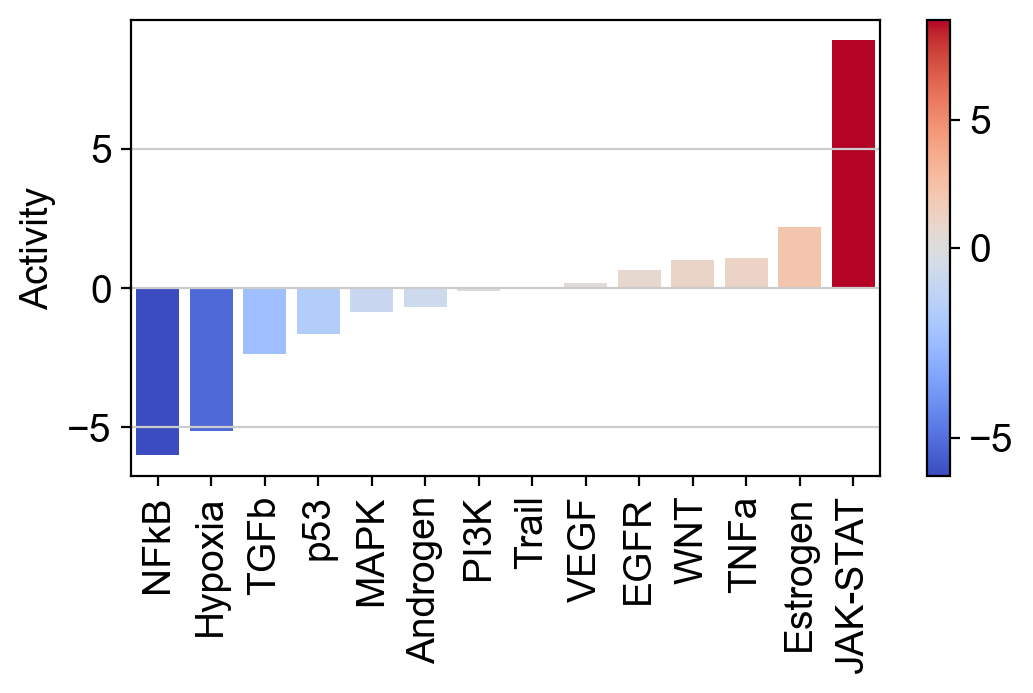

In [112]:
dc.plot_barplot(
    acts=pathway_acts,
    contrast='T cell',
    top=25,
    vertical=False,
    figsize=(6, 3)
)

It looks like JAK-STAT, a known immunity pathway is more active in T cells from COVID-19 patients than in controls. To further explore how the target genes of a pathway of interest behave, we can plot them in scatter plot:

JAK-STATという既知の免疫経路が、COVID-19患者のT細胞では対照細胞よりも活性化しているようだ。興味のある経路の標的遺伝子がどのように振る舞うかをさらに調べるには、散布図にプロットすればよい：

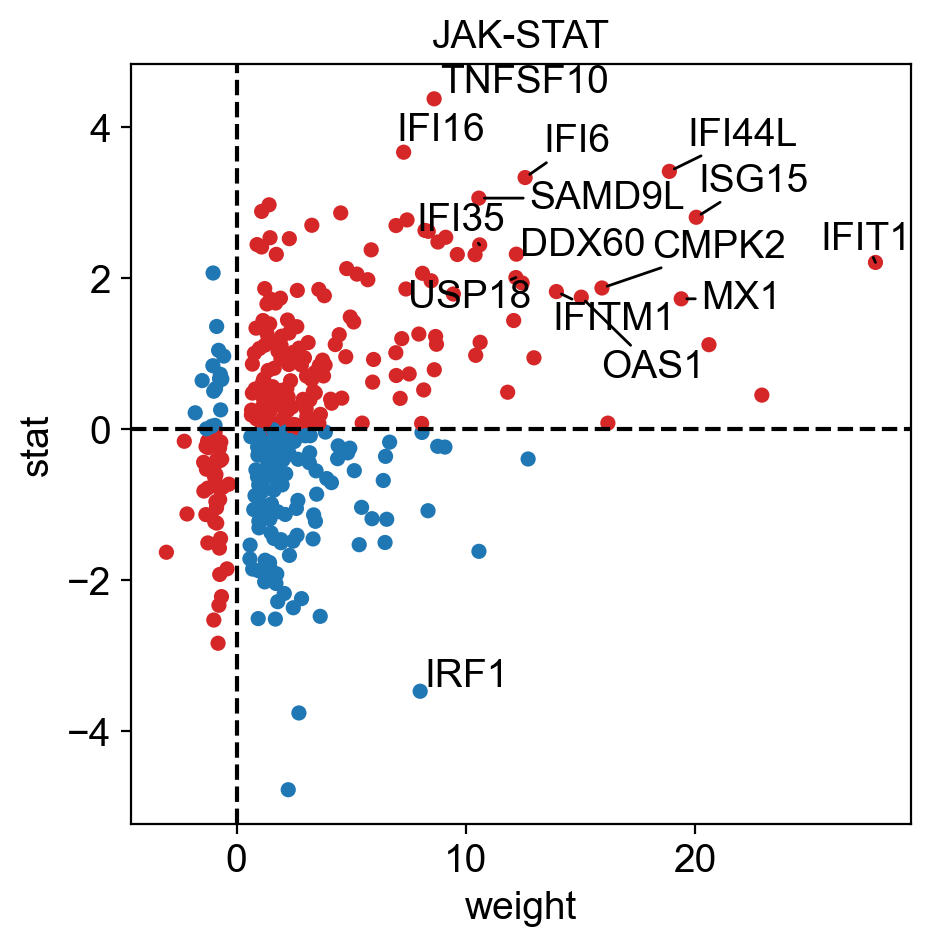

In [113]:
dc.plot_targets(
    data=results_df,
    stat='stat',
    source_name='JAK-STAT',
    net=progeny,
    top=15
)

The observed activation of JAK-STAT is due to the fact that majority of its target genes with positive weights have positive
t-values (1st quadrant), and the majority of the ones with negative weights have negative t-values (3d quadrant).

JAK-STATの活性化が観察されるのは、正の重みを持つ標的遺伝子の大半が正のt値を持ち（第1象限）、負の重みを持つ標的遺伝子の大半が負のt値を持つ（第3象限）からである。

## Functional enrichment of biological terms

Finally, we can also infer activities for general biological terms or processes.

### MSigDB gene sets

The Molecular Signatures Database ([MSigDB](http://www.gsea-msigdb.org/gsea/msigdb/)) is a resource containing a collection of gene sets annotated to different biological processes.

最後に、一般的な生物学用語や生物学的プロセスの活性を推測することもできる。

Molecular Signatures Database (MSigDB)は、様々な生物学的プロセスにアノテーションされた遺伝子セットのコレクションを含むリソースである。

In [114]:
# Retrieve MSigDB resource
msigdb = dc.get_resource('MSigDB')

In [115]:
msigdb.head()

,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP


As an example, we will use the hallmark gene sets, but we could have used any other.

We can filter by for `hallmark`:

例として、ホールマーク遺伝子セットを使うが、他のものでもよい。

hallmarkでフィルターできる：

In [116]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection'] == 'hallmark']

In [117]:
# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

In [118]:
# Rename
msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in msigdb['geneset']]

In [119]:
msigdb.head()

,genesymbol,collection,geneset
233,MAFF,hallmark,IL2_STAT5_SIGNALING
250,MAFF,hallmark,COAGULATION
270,MAFF,hallmark,HYPOXIA
373,MAFF,hallmark,TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,COMPLEMENT


### Enrichment with Over Representation Analysis (ORA)

To infer functional enrichment scores we will run the Over Representation Analysis (`ora`) method.
As input data it accepts an expression matrix (`decoupler.run_ora`) or the results of differential expression analysis (`decoupler.run_ora_df`).
For the former, by default the top 5% of expressed genes by sample are selected as the set of interest (S*), and for the latter a user-defined
significance filtering can be used.
Once we have S*, it builds a contingency table using set operations for each set stored in the gene set resource being used (`net`).
Using the contingency table, `ora` performs a one-sided Fisher exact test to test for significance of overlap between sets.
The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.
     
We can run `ora` with a simple one-liner:

機能的濃縮スコアを推測するために、Over Representation Analysis (ora)メソッドを実行する。入力データとして、発現行列(decoupler.run_ora)または差分発現解析結果(decoupler.run_ora_df)を受け取る。前者では、デフォルトでサンプルごとの発現遺伝子の上位5％が注目セット（S*）として選択され、後者ではユーザー定義の有意性フィルタリングを使用できる。S*が得られたら、使用する遺伝子セットリソース（net）に格納されている各セットについて、セット操作を使用して分割表を作成する。分割表を用いて、oraはセット間の重複の有意性を検定するために片側フィッシャー正確検定を実行する。最終的なスコアは得られたp値を対数変換することで得られ、値が大きいほど有意であることを意味する。

oraは簡単なワンライナーで実行できる：

In [121]:
results_df.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
A1BG,70.472333,-0.202972,0.259150,-0.783221,0.433497,0.847778
A2M,36.734556,-1.260096,0.355288,-3.546687,0.000390,0.031807
A2MP1,15.628607,0.601969,0.702298,0.857142,0.391366,0.829075
AAAS,18.306753,0.254730,0.453785,0.561346,0.574562,0.899853
AACS,24.631571,0.259419,0.383281,0.676837,0.498509,0.872643


In [122]:
# Infer enrichment with ora using significant deg
top_genes = results_df[results_df['padj'] < 0.05]

In [123]:
top_genes.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
A2M,36.734556,-1.260096,0.355288,-3.546687,0.000390,0.031807
ACTG1,2355.872592,0.677478,0.175299,3.864706,0.000111,0.015213
ADAM3A,22.761280,-1.362451,0.404315,-3.369776,0.000752,0.048912
ANKRD20A11P,17.108267,-2.843186,0.617010,-4.608009,0.000004,0.001211
ARHGAP22,84.875433,-0.989958,0.261169,-3.790497,0.000150,0.017589


In [124]:
# Run ora
enr_pvals = dc.get_ora_df(
    df=top_genes,
    net=msigdb,
    source='geneset',
    target='genesymbol'
)

In [125]:
enr_pvals.head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,ADIPOGENESIS,200,0.005000,0.803018,0.803018,0.922950,0.202475,PPP1R15B
1,ALLOGRAFT_REJECTION,200,0.010000,0.480065,0.550662,1.547894,1.135898,STAT4;TNF
2,APICAL_JUNCTION,200,0.005000,0.803018,0.803018,0.922950,0.202475,ACTG1
3,APOPTOSIS,161,0.055901,0.000006,0.000062,7.652652,91.547809,DNAJA1;FEZ1;GADD45B;IRF1;JUN;SQSTM1;TNF;TNFSF1...
4,CHOLESTEROL_HOMEOSTASIS,74,0.027027,0.119695,0.194505,4.192317,8.899479,ACTG1;S100A11


Then we can visualize the most enriched terms:

そして、最もエンリッチされた用語を視覚化することができる：

In [126]:
?dc.plot_dotplot

Signature:
dc.plot_dotplot(
    df,
    x,
    y,
    c,
    s,
    scale=5,
    cmap='viridis_r',
    title=None,
    figsize=(3, 5),
    dpi=100,
    ax=None,
    return_fig=False,
    save=None,
)
Docstring:
Plot results of enrichment analysis as dots.

Parameters
----------
df : DataFrame
    Results of enrichment analysis.
x : str
    Column name of ``df`` to use as continous value.
y : str
    Column name of ``df`` to use as labels.
c : str
    Column name of ``df`` to use for coloring.
s : str
    Column name of ``df`` to use for dot size.
scale : int
    Parameter to control the size of the dots.
cmap : str
    Colormap to use.
title : str, None
    Text to write as title of the plot.
figsize : tuple
    Figure size.
dpi : int
    DPI resolution of figure.
ax : Axes, None
    A matplotlib axes object. If None returns new figure.
return_fig : bool
    Whether to return a Figure object or not.
save : str, None
    Path to where to save the plot. Infer the filetype if ending on {`

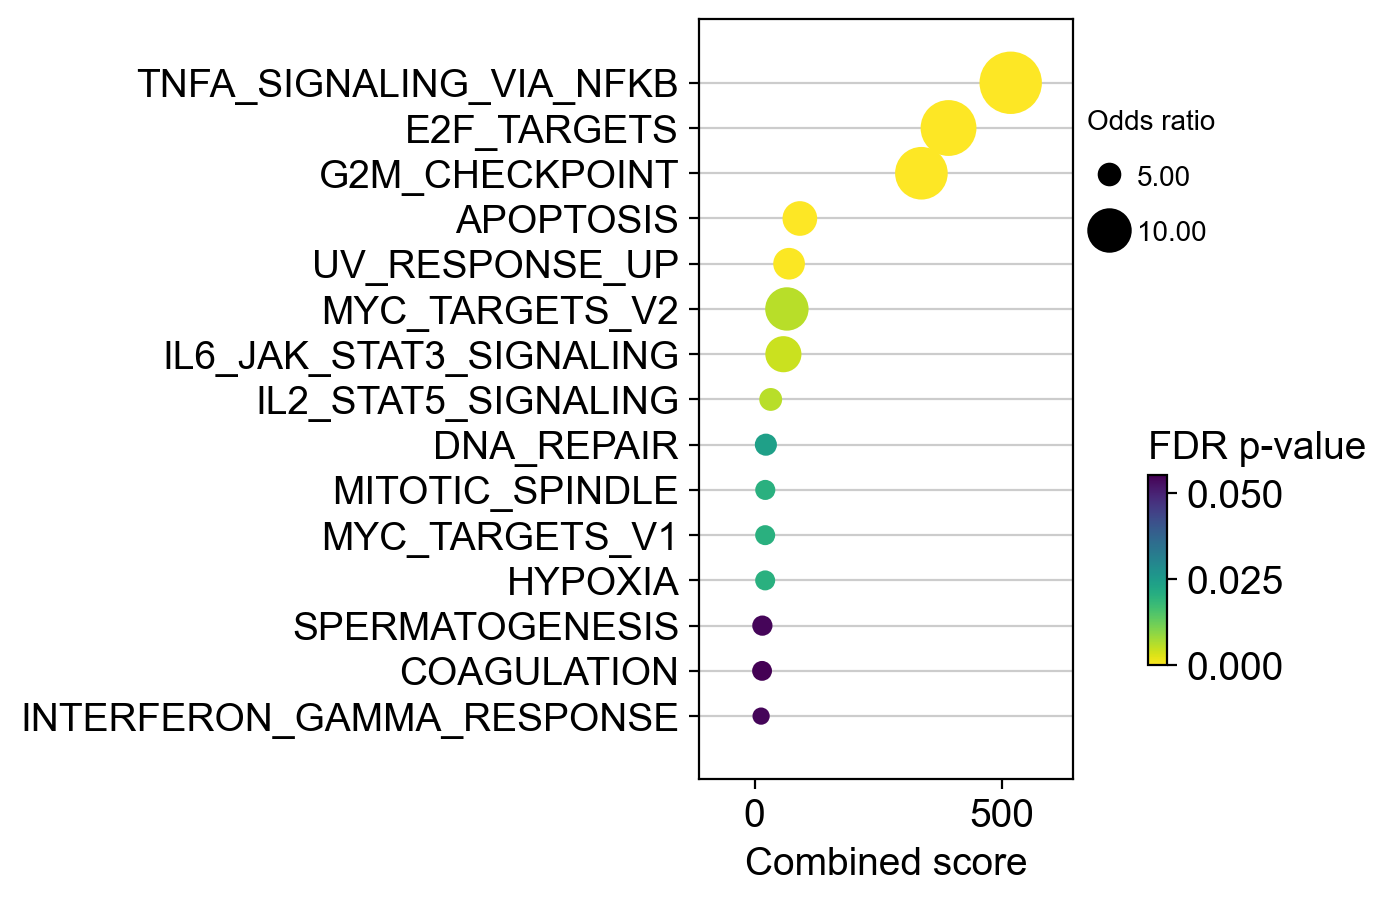

In [127]:
dc.plot_dotplot(
    enr_pvals.sort_values('Combined score', ascending=False).head(15),
    x='Combined score',
    y='Term',
    s='Odds ratio',
    c='FDR p-value',
    scale=0.25,
    # figsize=(3, 9)
)

We can also plot the running score for a given gene set:

また、与えられた遺伝子セットのランニングスコアをプロットすることもできる：

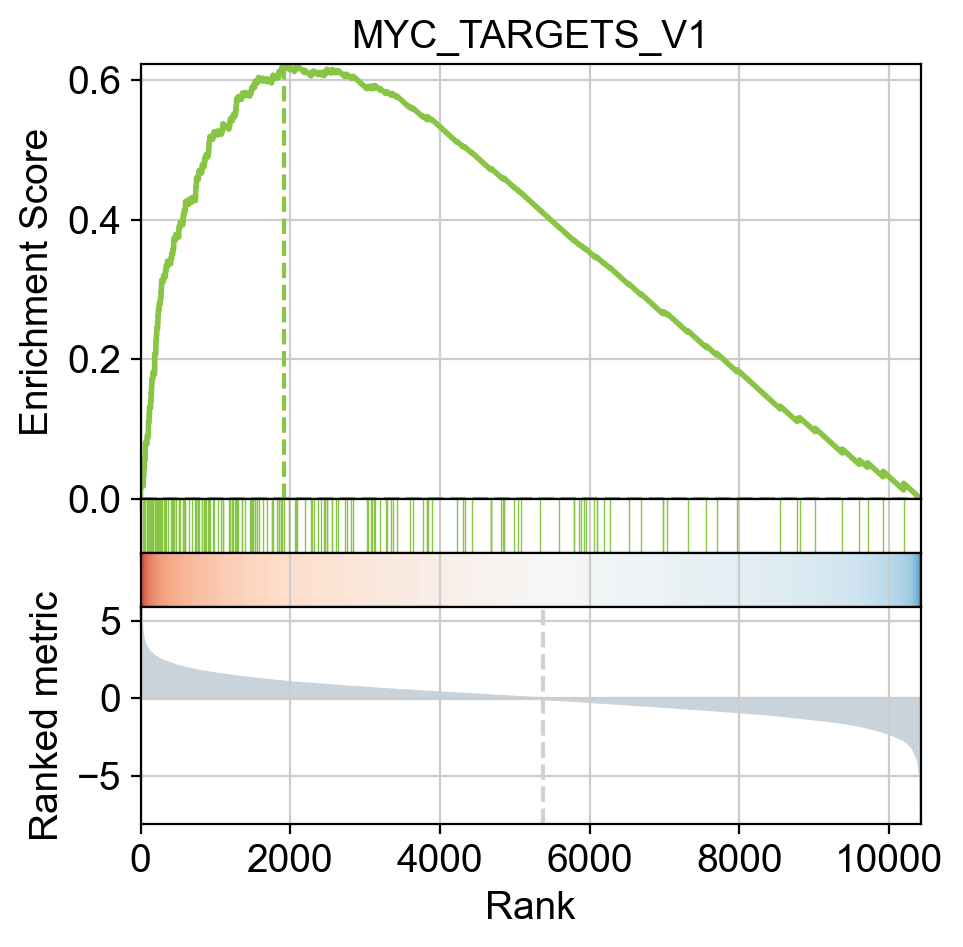

In [128]:
# Plot
dc.plot_running_score(
    df=results_df,
    stat='stat',
    net=msigdb,
    source='geneset',
    target='genesymbol',
    set_name='MYC_TARGETS_V1'
)